In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import CM4Xutils
CM4Xutils.__version__

'0.1.0'

In [69]:
import doralite
import gfdl_utils.core as gu

In [70]:
model = "CM4Xp25"
interval = "1850"
grid = CM4Xutils.load_wmt_grid(model, interval=interval, dmget=True)

Loading CM4Xp25-piControl for interval `1850`.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Loading CM4Xp25-historical for interval `1850`.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Overriding CM4Xp25 grid coordinates from supergrid.
Inferring Z grid coordinate: depth `z_`


In [71]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid, budgets_dict)

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [72]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict
    )
    wmb.mass_budget("sigma2", greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [73]:
%time wmt_mean = (wmt.sel(exp="control").mean("time")/1035*1e-6).compute()

CPU times: user 3h 53min 57s, sys: 4h 39min 44s, total: 8h 33min 41s
Wall time: 1h 27min 26s


In [74]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

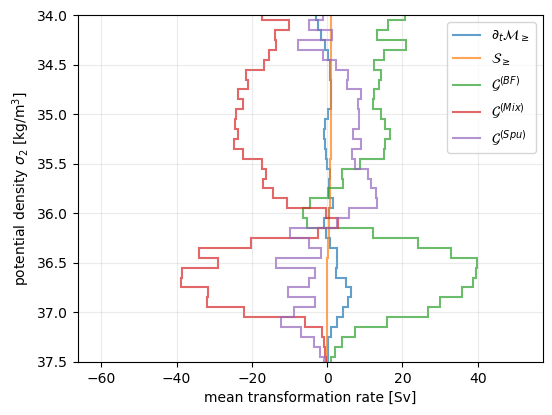

In [78]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs(-wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}_{\geq}$",**kwargs)
stairs( wmt_mean, 'mass_source',               label=r"$\mathcal{S}_{\geq}$",            **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Spu)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.0);